In [1]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

In [16]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset

DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

Training on cpu using PyTorch 1.12.1 and Flower 1.7.0


In [17]:
NUM_CLIENTS = 10
BATCH_SIZE = 32


def load_datasets():
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        batch["img"] = [transform(img) for img in batch["img"]]
        return batch

    # Create train/val for each partition and wrap it into DataLoader
    trainloaders = []
    valloaders = []
    for partition_id in range(NUM_CLIENTS):
        partition = fds.load_partition(partition_id, "train")
        partition = partition.with_transform(apply_transforms)
        partition = partition.train_test_split(train_size=0.8)
        trainloaders.append(DataLoader(partition["train"], batch_size=BATCH_SIZE))
        valloaders.append(DataLoader(partition["test"], batch_size=BATCH_SIZE))
    testset = fds.load_full("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

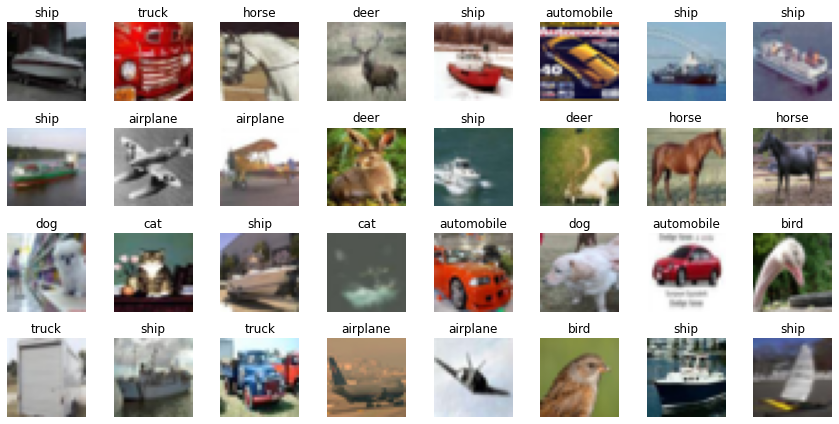

In [18]:
batch = next(iter(trainloaders[0]))
images, labels = batch["img"], batch["label"]
# Reshape and convert images to a NumPy array
# matplotlib requires images with the shape (height, width, 3)
images = images.permute(0, 2, 3, 1).numpy()
# Denormalize
images = images / 2 + 0.5

# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(12, 6))

# Loop over the images and plot them
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloaders[0].dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

# Show the plot
fig.tight_layout()
plt.show()

In [19]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [21]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.061342130422592164, accuracy 0.301
Epoch 2: validation loss 0.05539588642120361, accuracy 0.357
Epoch 3: validation loss 0.052577061772346494, accuracy 0.397
Epoch 4: validation loss 0.05093461072444916, accuracy 0.416
Epoch 5: validation loss 0.049317912936210635, accuracy 0.444
Final test set performance:
	loss 0.04874094249010086
	accuracy 0.4292


In [22]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [23]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

In [24]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    net = Net().to(DEVICE)

    # Load data (CIFAR-10)
    # Note: each client gets a different trainloader/valloader, so each client
    # will train and evaluate on their own unique data
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, trainloader, valloader).to_client()

In [25]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=10,  # Wait until all 10 clients are available
)

# Specify the resources each of your clients need. By default, each
# client will be allocated 1x CPU and 0x GPUs
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}
    # Refer to our documentation for more details about Flower Simulations
    # and how to setup these `client_resources`.

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2024-04-24 16:34:13,902 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-04-24 16:34:17,718	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-04-24 16:34:18,839 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 3196212020.0, 'node:10.133.3.105': 1.0, 'CPU': 12.0, 'node:__internal_head__': 1.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'object_store_memory': 1598106009.0}
INFO flwr 2024-04-24 16:34:18,839 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-04-24 16:34:18,840 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-04-24 16:34:18,848 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 12 actors
INFO flwr 2024-04-24 16:34:18,849 | server.py:89 | Initializing global parameters
INFO flwr 2024-04-24 16:34:18,849 | server.py:276

History (loss, distributed):
	round 1: 0.0635773538351059
	round 2: 0.05659616274833679
	round 3: 0.05237253422737122
	round 4: 0.050622486329078675
	round 5: 0.04899981343746185

In [12]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [13]:
# Create FedAvg strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=10,
    min_evaluate_clients=5,
    min_available_clients=10,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
    client_resources=client_resources,
)

INFO flwr 2024-03-08 10:47:56,345 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=5, round_timeout=None)
2024-03-08 10:47:59,667	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-03-08 10:48:00,879 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:10.133.24.246': 1.0, 'node:__internal_head__': 1.0, 'CPU': 12.0, 'memory': 3097790055.0, 'accelerator_type:G': 1.0, 'GPU': 1.0, 'object_store_memory': 1548895027.0}
INFO flwr 2024-03-08 10:48:00,880 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO flwr 2024-03-08 10:48:00,880 | app.py:242 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO flwr 2024-03-08 10:48:00,894 | app.py:288 | Flower VCE: Creating VirtualClientEngineActorPool with 12 actors
INFO flwr 2024-03-08 10:48:00,895 | server.py:89 | Initializing global parameters
INFO flwr 2024-03-08 10:48:00,895 | server.py:27

History (loss, distributed):
	round 1: 0.06217524333000183
	round 2: 0.05466834399700164
	round 3: 0.052569245290756225
	round 4: 0.04974737601280212
	round 5: 0.04963383665084839
History (metrics, distributed, evaluate):
{'accuracy': [(1, 0.3126), (2, 0.365), (3, 0.40259999999999996), (4, 0.4372), (5, 0.4288)]}

# To do:
## New Lightning wrapper


In [20]:
import torch
import pytorch_lightning as pl
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CyclicLR
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

class Net(pl.LightningModule):
    
    
    # /****** * * * *  *  *   *  *  *  *  * * *********/
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    # /****** * * * *  *  *   *  *  *  *  * * *********/
    
    
    def training_step(self, batch, batch_idx):
        images, labels = batch["img"], batch["label"]
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        self.log("train_loss", loss)
        return loss

    #def configure_optimizers(self):
    #    return torch.optim.Adam(self.parameters())

    def configure_optimizers(self):
        optim_dict = {
            "SGD": torch.optim.SGD(self.parameters(), lr=self.params.lr, momentum=0.9),
            "Adam": torch.optim.Adam(self.parameters(), lr=self.params.lr),
            "RMSprop": torch.optim.RMSprop(self.parameters(), lr=self.params.lr),
            "Adagrad": torch.optim.Adagrad(self.parameters(), lr=self.params.lr),
            "Adadelta": torch.optim.Adadelta(self.parameters(), lr=self.params.lr),
            "Adamax": torch.optim.Adamax(self.parameters(), lr=self.params.lr),
            "ASGD": torch.optim.ASGD(self.parameters(), lr=self.params.lr)
        }
        optimizer = optim_dict[self.params.optimizer]

        scheduler_dict = {
            "ReduceLROnPlateau": ReduceLROnPlateau(
                optimizer,
                "min",
                factor=float(self.params.lr_factor),
                patience=float(self.params.lr_patience),
                min_lr=float(self.params.lr_min),
            ),
            "StepLR": StepLR(optimizer, step_size=1, gamma=self.params.lr_factor),
            "MultiStepLR": MultiStepLR(
                optimizer, milestones=[1, 2, 3], gamma=self.params.lr_factor
            ),
            "ExponentialLR": ExponentialLR(optimizer, gamma=self.params.lr_factor),
            "CosineAnnealingLR": CosineAnnealingLR(
                optimizer, T_max=10, eta_min=float(self.params.lr_min)
            ),
            "CyclicLR": CyclicLR(
                optimizer,
                base_lr=self.params.lr_min,
                max_lr=self.params.lr,
                step_size_up=10,
                cycle_momentum=False,
            ),
            "CosineAnnealingWarmRestarts": CosineAnnealingWarmRestarts(
                optimizer, T_0=10, T_mult=1, eta_min=float(self.params.lr_min)
            ),
        }

        lr_scheduler = {
            "scheduler": scheduler_dict[self.params.lr_scheduler],
            "monitor": 'val_loss',
            "interval": "epoch",
            "frequency": 1,
        }
        #return {"optimizer": optimizer, "lr_scheduler": lr_scheduler, "monitor": "val_loss"}

        return [optimizer], [lr_scheduler]


    def test_step(self, batch, batch_idx):
        images, labels = batch["img"], batch["label"]
        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        correct = torch.sum(preds == labels)
        return {"test_loss": loss, "correct": correct, "total": len(labels)}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x["test_loss"] for x in outputs]).mean()
        total_correct = torch.stack([x["correct"] for x in outputs]).sum()
        total_items = torch.stack([x["total"] for x in outputs]).sum()
        accuracy = total_correct.float() / total_items
        self.log("test_loss", avg_loss)
        self.log("test_accuracy", accuracy)

    
"""trainloader = trainloaders[0]
valloader = valloaders[0]
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")"""

'trainloader = trainloaders[0]\nvalloader = valloaders[0]\nnet = Net().to(DEVICE)\n\nfor epoch in range(5):\n    train(net, trainloader, 1)\n    loss, accuracy = test(net, valloader)\n    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")\n\nloss, accuracy = test(net, testloader)\nprint(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")'

## Add Weights and biases could be nice
Ready to test once DataLoader is ready


In [18]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import RichProgressBar

def train(modelo, params):
    
    dataset.setup("fit")
    
    ## CSV Logger
    csv_logger = CSVLogger(params.log_path, name="", version="",prefix="")

    _logger=[csv_logger]
    ## Add WandB as option
    if params.wandb_track:
        wandb_logger=WandbLogger(project=params.wandb_project,name=params.wandb_run_name,save_dir=params.log_path)
        _logger.append(wandb_logger)
        
    ## Add TB also as an option
    model_checkpoint = ModelCheckpoint(
        dirpath=params.log_path,
        monitor="val_loss",
        save_top_k=params.save_top_k,
        every_n_epochs=params.every_n_epochs,
        filename="{epoch}-{val_loss:.4f}",
    )
    lr_monitor = LearningRateMonitor()
    rich_progress_bar = RichProgressBar()

    trainer = pl.Trainer(
        max_epochs=params.epochs,
        num_nodes=params.n_gpu_nodes,
        default_root_dir=params.log_path,
        callbacks=[model_checkpoint ,lr_monitor,rich_progress_bar],
        logger=_logger,
        gradient_clip_val=params.clip,
        log_every_n_steps = 1
    )
    trainer.fit(modelo, dataset)


## M&Ms lightning data loader
Data loader has to be adapted to Lightning DataModule for optimal performance

In [21]:
from pytorch_lightning import LightningDataModule

class MMsDataSet(LightningDataModule):
    def __init__(self, params):
        super(MMsDataSet, self).__init__()
        self.data = torch.load(params.dataset_root)
        self.params = params

        assert ( self.params.train_size + self.params.val_size + self.params.test_size ) <= 1.0 , "Sum of train + validation + test is larger than 1.0"

        if torch.cuda.is_available() and self.params.device == 'cuda':
            self.device = torch.device('cuda')
        else:
            self.device = torch.device("cpu")
        
    def setup(self, stage):
        self.len = len(self.data)
        indices = np.arange(self.len)
        np.random.shuffle(indices)

        train = self.params.train_with.copy()

    #if stage == "train":
        train_size=int(self.params.train_size * self.len)
        self.ind_train = indices[:train_size]
        self.train = Subset(self.data, self.ind_train)
        """for config in range(train_size):
            for key, value in self.train[config].items():
                if key in train:       
                    self.train[config][key] = value.to(self.device)
        """       
    #if stage == "val":
        val_size=int(self.params.val_size * self.len)
        self.ind_val = indices[train_size:val_size+train_size]
        self.val = Subset(self.data, self.ind_val)        

        """for config in range(val_size):
            for key, value in self.val[config].items():
                if key in train:       
                    self.val[config][key] = value.to(self.device)
        """
        #test_size=int(self.params.test_size * self.len )
        #self.ind_test = indices[train_size+val_size:]
        #self.test = Subset(self.data, self.ind_test)


    def train_dataloader(self):
        return self._get_dataloader(self.train, "train")

    def val_dataloader(self):
        return self._get_dataloader(self.val, "val")

    def test_dataloader(self):

        return self._get_dataloader(self.test, "test")

    def _get_dataloader(self, dataset, stage, store_dataloader=True):
        if stage == "train":
            shuffle_ = True
        else:
            shuffle_ = False

        data_loader = DataLoader(
            dataset=dataset,
            batch_size=self.params.batch_size,
            num_workers=self.params.num_workers,
            pin_memory=True,
            shuffle=shuffle_,
        )
        return data_loader


## New Flower strategy